In [44]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
import astropy.io.fits as fits
import glob
# Strangely these two aren't working again, but I suppose it shouldn't matter in this instance...
# still, I'd like to know what happened there, especially since we might need the bandpass one again at least.
#from lsst.sims.photUtils.Sed import Sed
#from lsst.sims.photUtils.Bandpass import Bandpass
import os
from sklearn.neighbors import KDTree

ModuleNotFoundError: No module named 'lsst.sims.photUtils.Bandpass'

Now with Steven's annotations!

In [5]:
plt.style.use('ggplot')

In [6]:
# our fake data:

with np.load('model_atm_mags.npz') as nump_zip:
    model_atm_mags = nump_zip['model_atm_mags']

In [7]:
# LSST sims fake data:

temp = np.load('stars_from_catsim.npz')
catsim_data = temp['from_catsim'].copy()
temp.close()

In [8]:
catsim_data

array([( 3500., -1.,  4.5,  29.15061  ,  27.86252  ,  26.88286  ),
       ( 2700., -0.,  2. ,  27.6896   ,  26.25251  ,  24.4602   ),
       ( 3400., -1.,  4.5,  22.9489   ,  21.66766  ,  20.55609  ), ...,
       ( 8950.,  1.,  3.5,  13.386506 ,  13.4968833,  13.6648923),
       ( 9200.,  1.,  4. ,  19.0695859,  19.1674051,  19.3290885),
       ( 8540.,  1.,  3.5,  14.2749375,  14.329094 ,  14.4727031)],
      dtype=[('teff', '<f8'), ('metallicity', '<f8'), ('logg', '<f8'), ('gmag', '<f8'), ('rmag', '<f8'), ('imag', '<f8')])

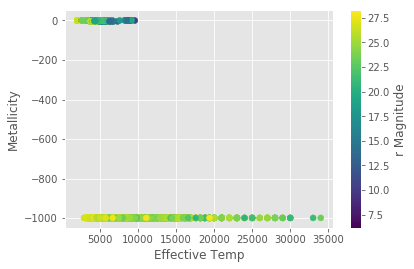

In [9]:
# Let's make sure our model parameter spaces are a reasonable match
plt.scatter(catsim_data['teff'], catsim_data['metallicity'], c=catsim_data['rmag'])
plt.xlabel('Effective Temp')
plt.ylabel('Metallicity')
cb = plt.colorbar()
cb.set_label('r Magnitude');

In [10]:
np.where(catsim_data['metallicity'] < -900)[0].size, catsim_data.size

(5374, 127426)

In [11]:
# ok, so 5k of the 127k have something that looks like a mask value of -999. Make a note to ask Scott what is up with that,
# but we'll just cut those for now.
catsim_data = catsim_data[np.where(catsim_data['metallicity'] > -900)]

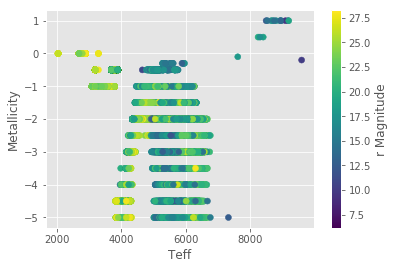

In [12]:
plt.scatter(catsim_data['teff'], catsim_data['metallicity'], c=catsim_data['rmag'])
cb = plt.colorbar()
cb.set_label('r Magnitude')
plt.xlabel('Teff')
plt.ylabel('Metallicity');

In [13]:
# I'm a little confused, those seem like amazingly low metallicity values for a lot of stars. 
# We'll go ahead and treat all of those like the minimum metallicity in our models.

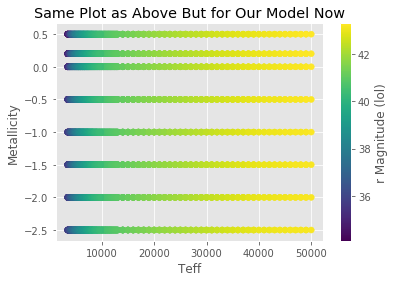

In [14]:
plt.scatter(model_atm_mags['Teff'], model_atm_mags['log_Z'], c=-1*model_atm_mags['r'])
cb = plt.colorbar()
plt.xlabel('Teff')
plt.ylabel('Metallicity')
cb.set_label('r Magnitude (lol)')
plt.title('Same Plot as Above But for Our Model Now');

In [15]:
# Now to match the catsim properties up to our model properties

# normalize all the parameters (our model fake data):

temp_norm = np.max(model_atm_mags['Teff'])
met_norm = np.max(model_atm_mags['log_Z'] ) - np.min(model_atm_mags['log_Z'])
logg_norm = np.max(model_atm_mags['gravity'] ) - np.min(model_atm_mags['gravity'])

model_X = np.array([model_atm_mags['Teff']/temp_norm,
                       model_atm_mags['log_Z']/met_norm,
                       model_atm_mags['gravity']/logg_norm]).T

model_kd_tree = KDTree(model_X)

In [16]:
# now to lookup the closest model index for each catsim star
catsim_vals = np.array([catsim_data['teff']/temp_norm,
              catsim_data['metallicity']/met_norm,
              catsim_data['logg']/logg_norm]).T
dist, indx_match = model_kd_tree.query(catsim_vals, k=1)

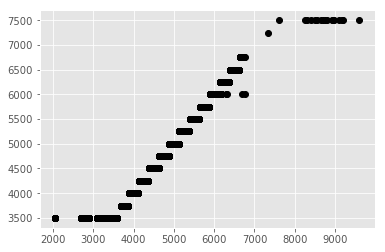

In [17]:
# check that we did kinda match things up in a reasonable way.
plt.plot(catsim_data['teff'], model_atm_mags['Teff'][indx_match], 'ko');

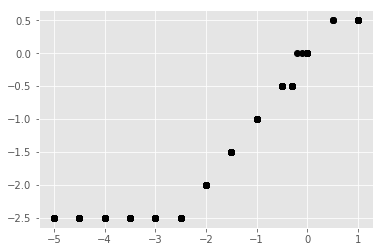

In [18]:
plt.plot(catsim_data['metallicity'], model_atm_mags['log_Z'][indx_match], 'ko');

In [19]:
# Let's construct a realistic catalog of stars with all the info from the model atmospheres
mag_cols = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861', 'u',
            'g', 'r', 'i', 'z', 'y']

In [20]:
truth_catalog = model_atm_mags[indx_match.ravel()]

In [21]:
dist_modulus = truth_catalog['r'] - catsim_data['rmag']

In [22]:
dist_modulus

array([-63.15321237, -61.06722329, -56.95835237, ..., -53.22021762,
       -58.89073942, -54.05242832])

In [23]:
# confirming what all's in truth_catalog:

truth_catalog.dtype

dtype([('Teff', '<f8'), ('log_Z', '<f8'), ('gravity', '<f8'), ('F378', '<f8'), ('F395', '<f8'), ('F410', '<f8'), ('F430', '<f8'), ('F515', '<f8'), ('F660', '<f8'), ('F861', '<f8'), ('u', '<f8'), ('g', '<f8'), ('r', '<f8'), ('i', '<f8'), ('z', '<f8'), ('y', '<f8')])

In [24]:
for mag_col in mag_cols:
    truth_catalog[mag_col] -= dist_modulus

In [45]:
np.savez('truth_catalog.npz', truth_catalog=truth_catalog)

First and second plots should look slightly different, which they do.

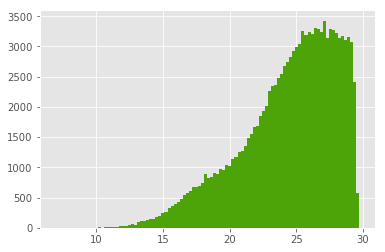

In [26]:
ack = plt.hist(truth_catalog['g'], bins=100, color='xkcd:Lawn Green')

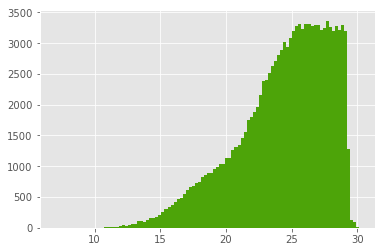

In [27]:
ack = plt.hist(catsim_data['gmag'], bins=100, color='xkcd:Lawn Green')

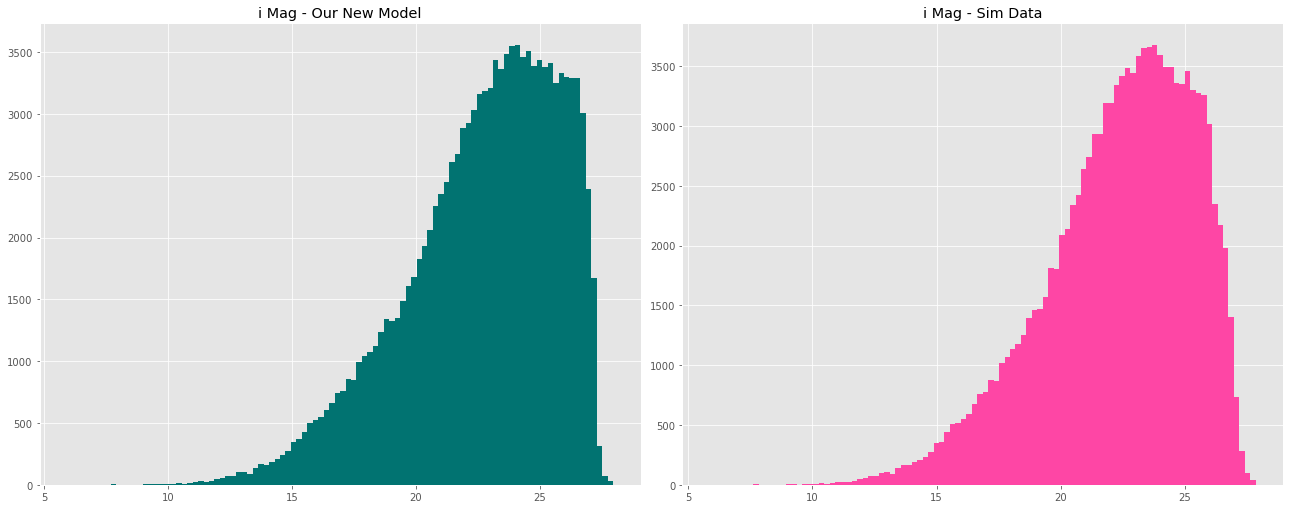

In [28]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(18,7)

fig.tight_layout()

ax[0].set_title('i Mag - Our New Model')
ax[0].hist(truth_catalog['i'], bins=100, color='xkcd:Dark Aquamarine')
ax[1].set_title('i Mag - Sim Data')
ax[1].hist(catsim_data['imag'], bins=100, color='xkcd:Barbie Pink');

In [29]:
np.median(catsim_data['gmag']-truth_catalog['g'])

-0.044552786268576838

In [30]:
# OK, those look pretty similar, the magnitudes in our new truth table have the same distribution as catsim


The next steps:

First, we need to make 2 kd-trees using the data in model_atm_mags. 1) a tree that lets one find the nearest model using (u-g), (g-r), (r-i), (i-z), (z-y). 2) a tree with those same broad colors, and also narrow colors. Maybe as (F378-u), (F395-u), (F861-i), etc where you use the broad band that covers the narrow band. 

Then, generate a realization of the magnitudes that LSST would observe (basically adding noise to the truth_catalog). We need to lookup the depths to figure out how much noise.

Finally, compare how well we recover the truth teff, metallicity, etc using each of the kd trees. 

finally working again...

In [31]:
color1 = model_atm_mags['u'] - model_atm_mags['g']
color2 = model_atm_mags['g'] - model_atm_mags['r']
color3 = model_atm_mags['r'] - model_atm_mags['i']
color4 = model_atm_mags['i'] - model_atm_mags['z']
color5 = model_atm_mags['z'] - model_atm_mags['y']

mag_model = np.array([color1, color2, color3, color4, color5]).T

In [32]:
broadleafed_tree = KDTree(mag_model)

In [33]:
bcolor1 = truth_catalog['u'] - truth_catalog['g']
bcolor2 = truth_catalog['g'] - truth_catalog['r']
bcolor3 = truth_catalog['r'] - truth_catalog['i']
bcolor4 = truth_catalog['i'] - truth_catalog['z']
bcolor5 = truth_catalog['z'] - truth_catalog['y']

sim_colors = np.array([bcolor1, bcolor2, bcolor3, bcolor4, bcolor5]).T
dist_bcolors, indx_match_bcolors = broadleafed_tree.query(sim_colors, k=1)

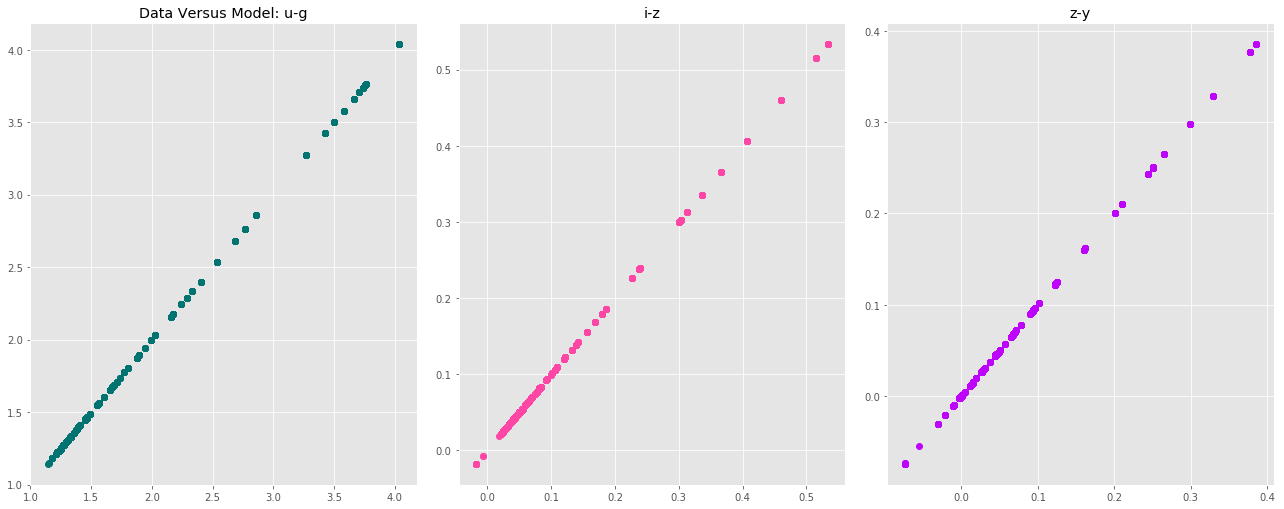

In [34]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

ax[0].set_title('Data Versus Model: u-g')
ax[0].plot(bcolor1, color1[indx_match_bcolors], 'ko', c='xkcd:Dark Aquamarine')

ax[1].set_title('i-z')
#ax[1].set_xlim(-0.2,1.75)
ax[1].plot(bcolor4, color4[indx_match_bcolors], 'ko', c='xkcd:Barbie Pink')

ax[2].set_title('z-y')
#ax[2].set_xlim(0.25,0.8)
#ax[2].set_ylim(0.2,0.9)
ax[2].plot(bcolor5, color5[indx_match_bcolors], 'ko', c='xkcd:Bright Purple');

Looks aight.

### Narrowband KD-Tree:

In [35]:
model_ncolor0 = model_atm_mags['F861'] - model_atm_mags['z']
model_ncolor1 = model_atm_mags['r'] - model_atm_mags['F660']
model_ncolor2 = model_atm_mags['g'] - model_atm_mags['F515']
model_ncolor3 = model_atm_mags['F430'] - model_atm_mags['g']
model_ncolor4 = model_atm_mags['F410'] - model_atm_mags['g']
# could really go with either:
model_ncolor5a = model_atm_mags['F395'] - model_atm_mags['g']
# or:
model_ncolor5b = model_atm_mags['u'] - model_atm_mags['F395']
# or both, I suppose, if there's anything to be gained from doing so.
model_ncolor6 = model_atm_mags['u'] - model_atm_mags['F378']

In [36]:
ncolormodel = np.array([model_ncolor0, model_ncolor1, model_ncolor2, model_ncolor3, model_ncolor4, model_ncolor5b, model_ncolor6]).T

In [37]:
narrowleafed_tree = KDTree(ncolormodel)

### Next: make truth_catalog NB colors!

In [38]:
nbcolor0 = truth_catalog['F861'] - truth_catalog['z']
nbcolor1 = truth_catalog['r'] - truth_catalog['F660']
nbcolor2 = truth_catalog['g'] - truth_catalog['F515']
nbcolor3 = truth_catalog['F430'] - truth_catalog['g']
nbcolor4 = truth_catalog['F410'] - truth_catalog['g']
# could really go with either:
nbcolor5a = truth_catalog['F395'] - truth_catalog['g']
# or:
nbcolor5b = truth_catalog['u'] - truth_catalog['F395']
# or both, I suppose, if there's anything to be gained from doing so.
nbcolor6 = truth_catalog['u'] - truth_catalog['F378']

nbsim_colors = np.array([nbcolor0, nbcolor1, nbcolor2, nbcolor3, nbcolor4, nbcolor5b, nbcolor6]).T
dist_nbcolors, indx_match_nbcolors = narrowleafed_tree.query(nbsim_colors, k=1)

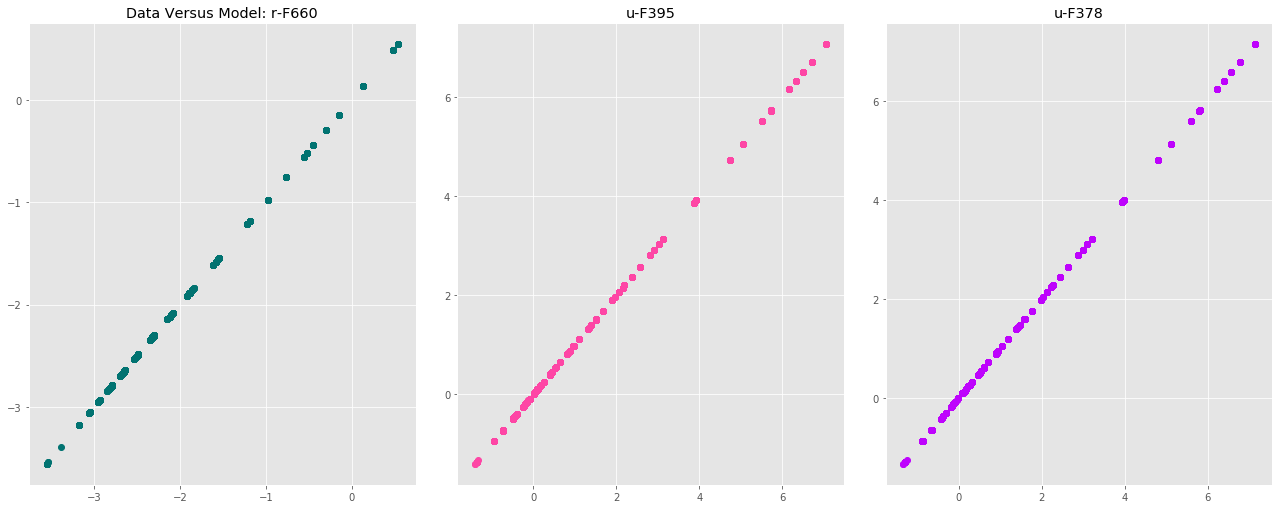

In [39]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

ax[0].set_title('Data Versus Model: r-F660')
ax[0].plot(nbcolor1, model_ncolor1[indx_match_nbcolors], 'ko', c='xkcd:Dark Aquamarine')

ax[1].set_title('u-F395')
#ax[1].set_xlim(-0.2,1.75)
ax[1].plot(nbcolor5b, model_ncolor5b[indx_match_bcolors], 'ko', c='xkcd:Barbie Pink')

ax[2].set_title('u-F378')
#ax[2].set_xlim(0.25,0.8)
#ax[2].set_ylim(0.2,0.9)
ax[2].plot(nbcolor6, model_ncolor6[indx_match_bcolors], 'ko', c='xkcd:Bright Purple');

Looks like I'd expect it to. Last two look basically the same, which, I suppose, they should.

Checking Teff and friends:

# For reference: x-axis = truth_catalog; y-axis = model_atm_mags.

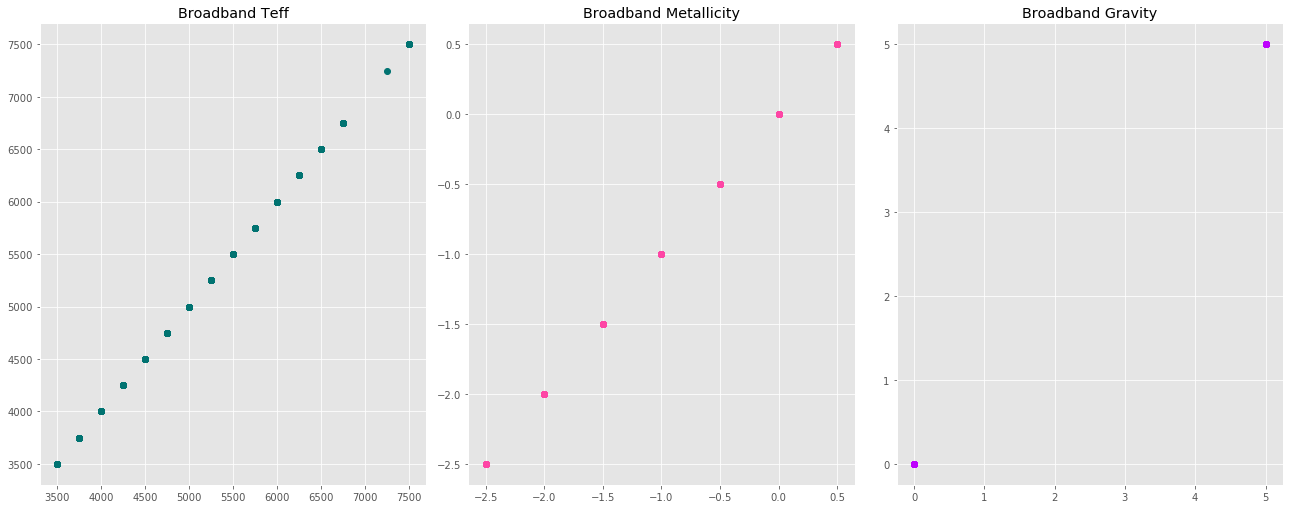

In [40]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

ax[0].set_title('Broadband Teff')
ax[0].plot(truth_catalog['Teff'], model_atm_mags['Teff'][indx_match_bcolors], 'ko', c='xkcd:Dark Aquamarine')

ax[1].set_title('Broadband Metallicity')
ax[1].plot(truth_catalog['log_Z'], model_atm_mags['log_Z'][indx_match_bcolors], 'ko', c='xkcd:Barbie Pink')

ax[2].set_title('Broadband Gravity')
ax[2].plot(truth_catalog['gravity'], model_atm_mags['gravity'][indx_match_bcolors], 'ko', c='xkcd:Bright Purple');

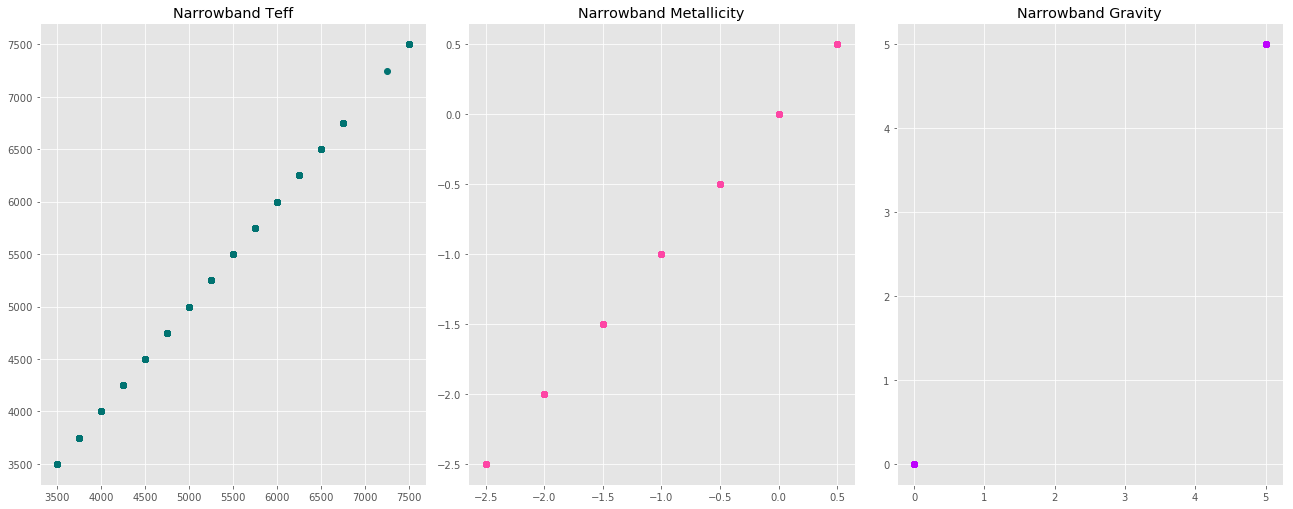

In [41]:
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,7)

fig.tight_layout()

ax[0].set_title('Narrowband Teff')
ax[0].plot(truth_catalog['Teff'], model_atm_mags['Teff'][indx_match_nbcolors], 'ko', c='xkcd:Dark Aquamarine')

ax[1].set_title('Narrowband Metallicity')
ax[1].plot(truth_catalog['log_Z'], model_atm_mags['log_Z'][indx_match_nbcolors], 'ko', c='xkcd:Barbie Pink')

ax[2].set_title('Narrowband Gravity')
ax[2].plot(truth_catalog['gravity'], model_atm_mags['gravity'][indx_match_nbcolors], 'ko', c='xkcd:Bright Purple');

More straight lines. Looks like we've done things right up to this points, so that's nice. It looks like gravity only has two values though?